# Toxic Comment Classification
## Introduction
Discussing things you care about can be difficult. The threat of abuse and harassment online means that many people stop expressing themselves and give up on seeking different opinions. Platforms struggle to effectively facilitate conversations, leading many communities to limit or completely shut down user comments.

One area of focus is the study of negative online behaviors, like toxic comments (i.e. comments that are rude, disrespectful or otherwise likely to make someone leave a discussion).

Here, we would try to build a multi-headed model that’s capable of detecting different types of of toxicity like threats, obscenity, insults, and identity-based hate. 

ref: https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/

## Data

We’ll be using a dataset of comments from Wikipedia’s talk page edits. Improvements to the current model will hopefully help online discussion become more productive and respectful. The corpus contains 63M comments from discussions relating to user pages and articles dating from 2004-2015.

<i>Disclaimer: the dataset for this competition contains text that may be considered profane, vulgar, or offensive. </i>

We are provided with a large number of Wikipedia comments which have been labeled by human raters for toxic behavior. The types of toxicity are:

- toxic
- severe_toxic
- obscene
- threat
- insult
- identity_hate

The tagging was done via crowdsourcing which means that the dataset was rated by different people and the tagging might not be 100% accurate too. 

The source paper also contains more interesting details about the dataset creation. (link to source paper: https://arxiv.org/pdf/1610.08914.pdf)

In [1]:
import pandas as  pd
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer

train.csv is the training set containing comments with their binary labels for each toxicity category

## 1. Reading Data

In [2]:
data=pd.read_csv("train.csv")
data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [3]:
test_data=pd.read_csv("test.csv")
test_data.head(3)

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."


## 2. Understanding Data
### sample comment text

In [4]:
data.loc[2, 'comment_text']

"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info."

In [5]:
data.loc[33, 'comment_text']

"I was able to post the above list so quickly because I already had it in a text file in my hard drive  I've been meaning to get around to updating the sound list for some time now. \nAs far as generating interest  I've spent four years trying to drum up more interest in freely licensed full length classical music. Unfortunately, my attempts failed - I'm still effectively the only one who does it. The classical music wikiproject was not interested, (Wikipedia_talk:WikiProject_Classical_music/Archive_5#Need_help.21Wikipedia_talk:WikiProject_Music/Archive_3#I_could_use_some_helpWikipedia_talk:WikiProject_Music/Archive_2#Raulbot.2C_and_the_music_list) So I really had given up trying to interest others.  \nThe sound list was featured on digg a while back - http://digg.com/music/Wikipedia_has_free_classical_music_downloads . It got 1600 diggs, which is IMO very impressive."

### Comment text length analysis

In [6]:
data['comment_text'].str.len().describe()

count    159571.000000
mean        394.073221
std         590.720282
min           6.000000
25%          96.000000
50%         205.000000
75%         435.000000
max        5000.000000
Name: comment_text, dtype: float64

We can see the lengths of comment varies a lot as largest comment has 5000 words while smallest comment has length of only 6 words.

Also, the mean and median of length differs a lot as well (mean of 394 words vs. median of 205 words).

In [7]:
labels=data.columns.tolist()
labels.remove('id')
labels.remove('comment_text')
print(labels)

['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']


In [8]:
#Analysis: tags per comments
data['label_num']= data[labels].sum(axis=1)
data.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,label_num
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,0


In [9]:
data['label_num'].value_counts()

0    143346
1      6360
3      4209
2      3480
4      1760
5       385
6        31
Name: label_num, dtype: int64

In [10]:

print("Out of total", data['label_num'].value_counts().sum(), "comments,", data['label_num'].value_counts().tolist()[0],
     "are non-toxic.")

Out of total 159571 comments, 143346 are non-toxic.


In [11]:
import seaborn as sns
import matplotlib.pyplot as plot

No. of comments per each toxic category

In [12]:
data[labels].sum(axis=0)

toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
dtype: int64

Text(0.5,0,'Label')

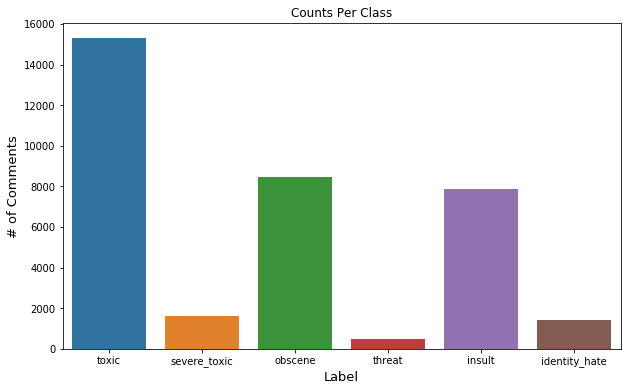

In [13]:
# plotting the label counts
plot.figure(figsize=(10,6))
ax = sns.barplot(data[labels].sum(axis=0).index, data[labels].sum(axis=0).values )
plot.title("Counts Per Class")
plot.ylabel('# of Comments', fontsize=13)
plot.xlabel('Label', fontsize=13)

### Sample comments for each toxic category

In [14]:
# Analysing toxic text for each category
# Disclaimer: text may contain profane, vulgar, or offensive language.
for lab in labels:
    print("label: ", lab)
    print("Comment text sample:")
    print(data[data[lab]==1].iloc[3, 1])
    print("----------------------------")
    

label:  toxic
Comment text sample:
You are gay or antisemmitian? 

Archangel WHite Tiger

Meow! Greetingshhh!

Uh, there are two ways, why you do erased my comment about WW2, that holocaust was brutally slaying of Jews and not gays/Gypsys/Slavs/anyone...

1 - If you are anti-semitian, than shave your head bald and go to the skinhead meetings!

2 - If you doubt words of the Bible, that homosexuality is a deadly sin, make a pentagram tatoo on your forehead go to the satanistic masses with your gay pals!

3 - First and last warning, you fucking gay - I won't appreciate if any more nazi shwain would write in my page! I don't wish to talk to you anymore!

Beware of the Dark Side!
----------------------------
label:  severe_toxic
Comment text sample:
Hi 

Im a fucking bitch.

50.180.208.181
----------------------------
label:  obscene
Comment text sample:
GET FUCKED UP. GET FUCKEEED UP.  GOT A DRINK THAT YOU CANT PUT DOWN???/ GET FUCK UP GET FUCKED UP.  I'M FUCKED UP RIGHT NOW!
-------------

### 2.1 Text data Cleaning

In [15]:
# text cleaning
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [16]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

In [17]:
from nltk.stem.wordnet import WordNetLemmatizer
lemma = WordNetLemmatizer()

In [18]:
# Combining all the above stundents 
from tqdm import tqdm as tqdm
def preprocess_text(text_data):
    preprocessed_text = []
    # tqdm is for printing the status bar
    for sentance in tqdm(text_data):
        sent = decontracted(sentance)
        sent = sent.replace('\\r', ' ')
        sent = sent.replace('\\n', ' ')
        sent = sent.replace('\\"', ' ')
        sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
        words = [lemma.lemmatize(word, "v") for word in sent.split()]
        sent = ' '.join(e for e in words if e.lower() not in stopwords)
        preprocessed_text.append(sent.lower().strip())
    return preprocessed_text

In [19]:
data['cleared_text1'] = preprocess_text(data.comment_text.values)

100%|████████████████████████████████████████████████████████████████████████| 159571/159571 [01:33<00:00, 1700.86it/s]


In [20]:
test_data['cleared_text1'] = preprocess_text(test_data.comment_text.values)

100%|████████████████████████████████████████████████████████████████████████| 153164/153164 [01:21<00:00, 1882.03it/s]


In [21]:
# ref: https://www.kaggle.com/asrsaiteja/toxic-comments-featureeng-eda-with-nb-baseline
def get_topn_tfidf_feat_byClass(X_tfidf, y_train, feature_names, labels, topn):
    
    feat_imp_dfs = {}
    
    for label in labels:
        # get indices of rows where label is true
        label_ids = y_train.index[y_train[label] == 1]
        # get subset of rows
        label_rows = X_tfidf[label_ids].toarray()
        # calc mean feature importance
        feat_imp = label_rows.mean(axis = 0)
        # sort by column dimension and get topn feature indices
        topn_ids = np.argsort(feat_imp)[::-1][:topn]
        # combine tfidf value with feature name
        topn_features = [(feature_names[i], feat_imp[i]) for i in topn_ids]
        # df
        topn_df = pd.DataFrame(topn_features, columns = ['word_feature', 'tfidf_value'])
        # save 
        feat_imp_dfs[label] = topn_df
    return feat_imp_dfs



tfidf = TfidfVectorizer(ngram_range = (1,1), min_df = 100, 
                        strip_accents='unicode', analyzer='word',
                        use_idf=1,smooth_idf=1,sublinear_tf=1,
                        stop_words = 'english')
X_unigrams = tfidf.fit_transform(data['comment_text'])
X_unigrams.shape, len(tfidf.get_feature_names())
feature_names = np.array(tfidf.get_feature_names())


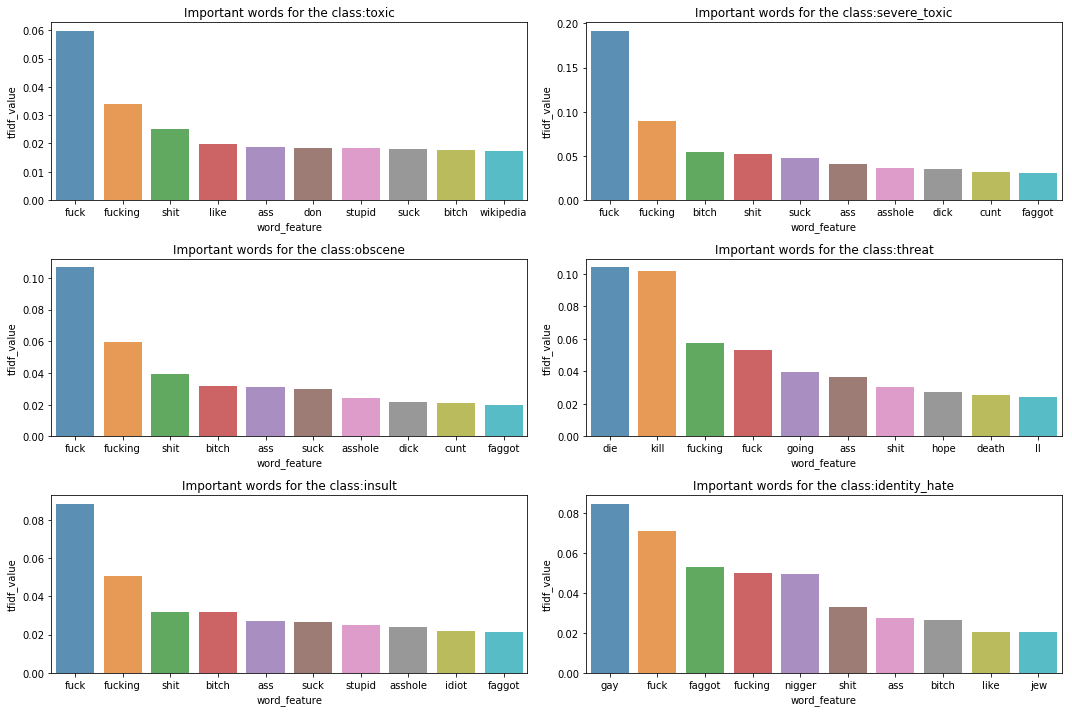

In [22]:
imp_dfs = get_topn_tfidf_feat_byClass(X_unigrams, data, feature_names, labels, topn = 10)
plot.figure(figsize=(15,10))

for i, label in enumerate(labels):
    plot.subplot(3, 2, i + 1)
    sns.barplot(imp_dfs[label].word_feature[:10], imp_dfs[label].tfidf_value[:10], alpha = 0.8)
    plot.title("Important words for the class:{}".format(label))
    plot.tight_layout()


### most common words for each category

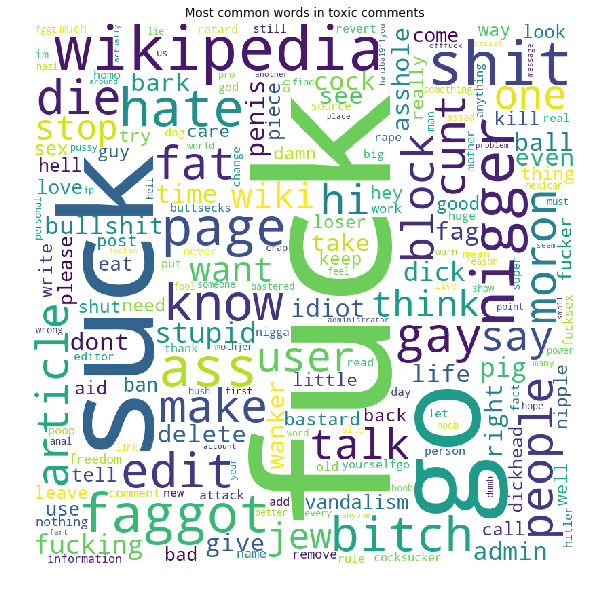

In [23]:
from wordcloud import WordCloud

comment_words =''
for string in data[data.toxic==1].cleared_text1.values:
    comment_words += string + ' '

wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                collocations = False, 
                min_font_size = 10).generate(comment_words) 

plot.figure(figsize = (8, 8), facecolor = None) 
plot.imshow(wordcloud) 
plot.title("Most common words in toxic comments")
plot.axis("off") 
plot.tight_layout(pad = 0) 
  
plot.show() 

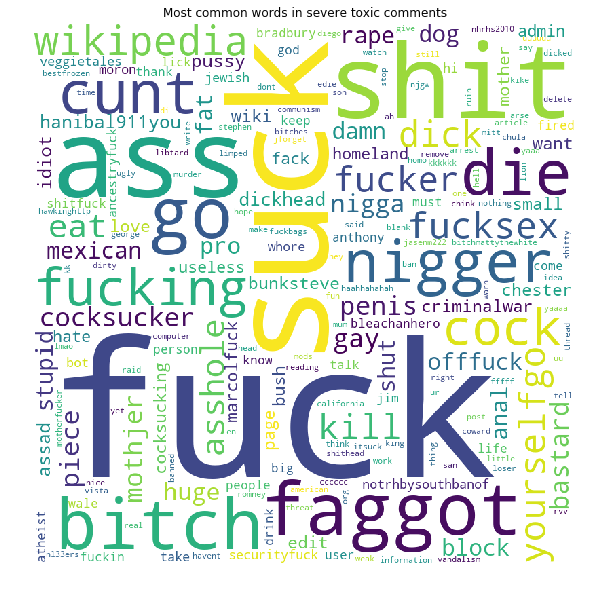

In [24]:
from wordcloud import WordCloud

comment_words =''
for string in data[data.severe_toxic==1].cleared_text1.values:
    comment_words += string + ' '

wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', collocations = False,  
                min_font_size = 10).generate(comment_words) 

plot.figure(figsize = (8, 8), facecolor = None) 
plot.imshow(wordcloud) 
plot.title("Most common words in severe toxic comments")
plot.axis("off") 
plot.tight_layout(pad = 0) 
  
plot.show() 

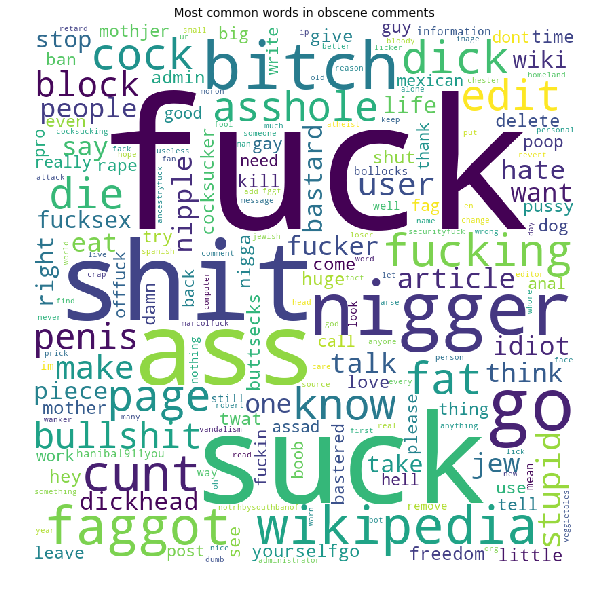

In [25]:
from wordcloud import WordCloud

comment_words =''
for string in data[data.obscene==1].cleared_text1.values:
    comment_words += string + ' '

wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                collocations = False, 
                min_font_size = 10).generate(comment_words) 

plot.figure(figsize = (8, 8), facecolor = None) 
plot.imshow(wordcloud) 
plot.title("Most common words in obscene comments")
plot.axis("off") 
plot.tight_layout(pad = 0) 
  
plot.show() 

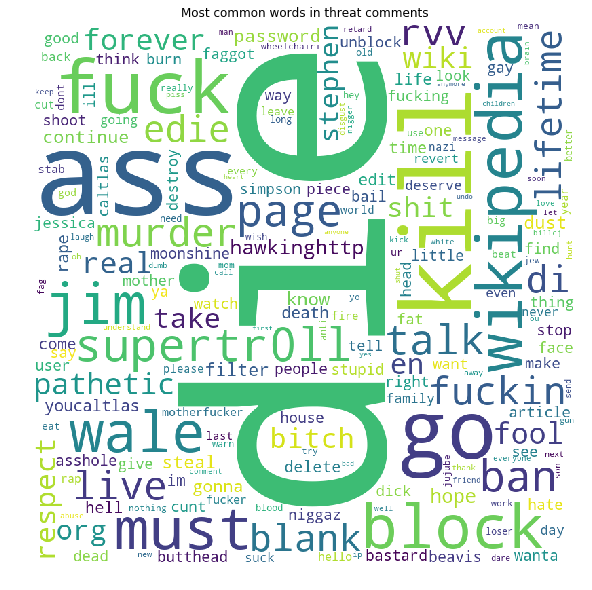

In [26]:
from wordcloud import WordCloud

comment_words =''
for string in data[data.threat==1].cleared_text1.values:
    comment_words += string + ' '

wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                collocations = False,  
                min_font_size = 10).generate(comment_words) 

plot.figure(figsize = (8, 8), facecolor = None) 
plot.imshow(wordcloud) 
plot.title("Most common words in threat comments")
plot.axis("off") 
plot.tight_layout(pad = 0) 
  
plot.show() 

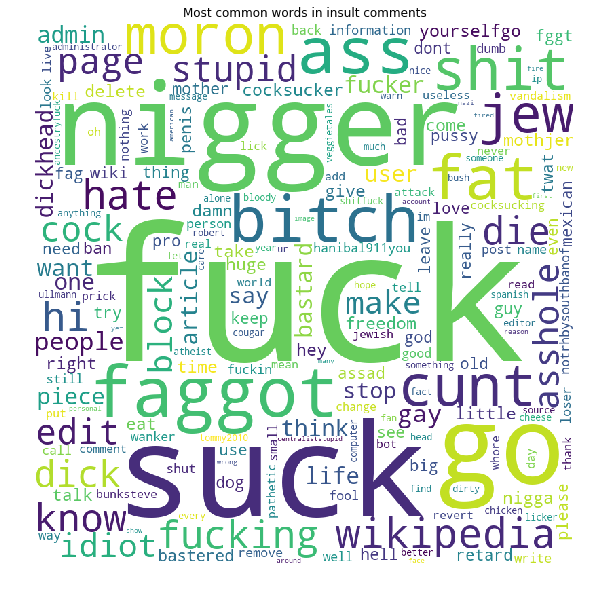

In [27]:
from wordcloud import WordCloud

comment_words =''
for string in data[data.insult==1].cleared_text1.values:
    comment_words += string + ' '

wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                collocations = False, 
                min_font_size = 10).generate(comment_words) 

plot.figure(figsize = (8, 8), facecolor = None) 
plot.imshow(wordcloud) 
plot.title("Most common words in insult comments")
plot.axis("off") 
plot.tight_layout(pad = 0) 
  
plot.show() 

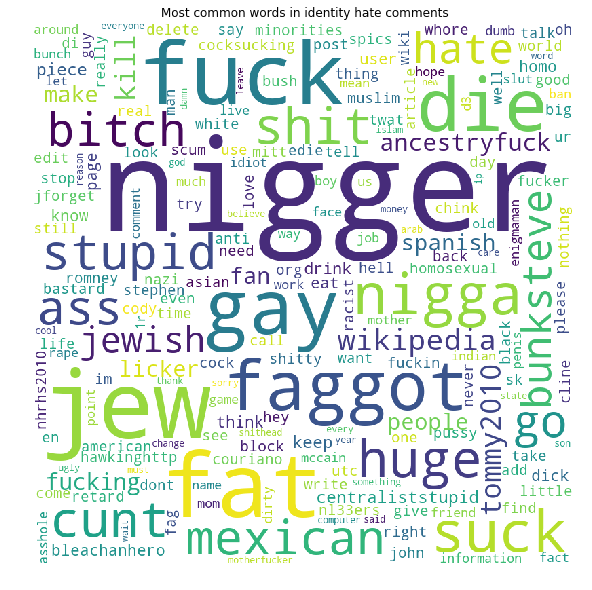

In [28]:
from wordcloud import WordCloud

comment_words =''
for string in data[data.identity_hate==1].cleared_text1.values:
    comment_words += string + ' '

wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                collocations = False, 
                min_font_size = 10).generate(comment_words) 

plot.figure(figsize = (8, 8), facecolor = None) 
plot.imshow(wordcloud) 
plot.title("Most common words in identity hate comments")
plot.axis("off") 
plot.tight_layout(pad = 0) 
  
plot.show() 

## 3. ML Models
### 3.0 Evaluation metric

We will be evaluating model performance using the mean column-wise ROC AUC. In other words, the score is the average of the individual AUCs of each predicted column.


### 3.1 Train test split

In [29]:
from sklearn.model_selection import train_test_split

In [31]:
X_train, X_val, y_train, y_val = train_test_split(data['cleared_text1'], 
                                                  data[labels], test_size=0.1, random_state=1919)
X_test=test_data['cleared_text1']
tfidf = TfidfVectorizer(ngram_range = (1,3), max_features=10000)
X_train = tfidf.fit_transform(X_train)
X_val = tfidf.transform(X_val)
X_test = tfidf.transform(X_test)
feature_names = tfidf.get_feature_names()

print('Final Data dimensions after transformations:', X_train.shape, y_train.shape, X_val.shape, y_val.shape)

Final Data dimensions after transformations: (143613, 10000) (143613, 6) (15958, 10000) (15958, 6)


### 3.2 Naive Bayes
#### 3.2.1 hyper parameter tuning

In [32]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, roc_auc_score

# model = LogisticRegression(C=3)


#preds_test = np.zeros((len(test_df), len(label_col)))
alphas= [0.001, 0.01, 0.1, 1, 10, 100, 1000]
train_roc_mean=[]
val_roc_mean=[]
for alp in alphas:
    print("for alpha=", alp)
    train_rocs = []
    valid_rocs = []

    preds_train = np.zeros(y_train.shape)
    preds_valid = np.zeros(y_val.shape)
    for i, label_name in enumerate(labels):
        # fit
        model = MultinomialNB(alpha=alp)
        model.fit(X_train,y_train[label_name])

        # train
        preds_train[:,i] = model.predict_proba(X_train)[:,1]
        train_roc_class = roc_auc_score(y_train[label_name],preds_train[:,i])
        train_rocs.append(train_roc_class)

        # valid
        preds_valid[:,i] = model.predict_proba(X_val)[:,1]
        valid_roc_class = roc_auc_score(y_val[label_name],preds_valid[:,i])
        valid_rocs.append(valid_roc_class)

    print('\nmean column-wise ROC AUC on Train data: ', np.mean(train_rocs))
    train_roc_mean.append(np.mean(train_rocs))
    print('mean column-wise ROC AUC on Val data:', np.mean(valid_rocs))
    val_roc_mean.append(np.mean(valid_rocs))
    print('*'*50)

for alpha= 0.001

mean column-wise ROC AUC on Train data:  0.9804756171963823
mean column-wise ROC AUC on Val data: 0.943238496064159
**************************************************
for alpha= 0.01

mean column-wise ROC AUC on Train data:  0.9796858736692707
mean column-wise ROC AUC on Val data: 0.9509158804956107
**************************************************
for alpha= 0.1

mean column-wise ROC AUC on Train data:  0.9776564416128739
mean column-wise ROC AUC on Val data: 0.9565998751367714
**************************************************
for alpha= 1

mean column-wise ROC AUC on Train data:  0.9610401339523474
mean column-wise ROC AUC on Val data: 0.9416001762697533
**************************************************
for alpha= 10

mean column-wise ROC AUC on Train data:  0.8908531026672627
mean column-wise ROC AUC on Val data: 0.8726036726128338
**************************************************
for alpha= 100

mean column-wise ROC AUC on Train data:  0.8123196668148406
mean 

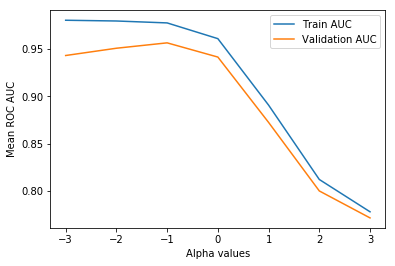

In [36]:
plot.plot(np.log10(alphas), train_roc_mean, label="Train AUC")
plot.plot(np.log10(alphas), val_roc_mean, label="Validation AUC")
plot.xlabel("Alpha values")
plot.ylabel("Mean ROC AUC")
plot.legend()
plot.show()

#### 3.2.2 NB Model with tuned alpha

In [37]:
model = MultinomialNB(0.1)

train_rocs = []
valid_rocs = []

preds_train = np.zeros(y_train.shape)
preds_valid = np.zeros(y_val.shape)
preds_test = np.zeros((len(test_data), len(labels)))

for i, label_name in enumerate(labels):
    print('\nClass:= '+label_name)
    # fit
    model.fit(X_train,y_train[label_name])
    
    # train
    preds_train[:,i] = model.predict_proba(X_train)[:,1]
    train_roc_class = roc_auc_score(y_train[label_name],preds_train[:,i])
    print('Train ROC AUC:', train_roc_class)
    train_rocs.append(train_roc_class)

    # valid
    preds_valid[:,i] = model.predict_proba(X_val)[:,1]
    valid_roc_class = roc_auc_score(y_val[label_name],preds_valid[:,i])
    print('Valid ROC AUC:', valid_roc_class)
    valid_rocs.append(valid_roc_class)
    
    # test predictions
    preds_test[:,i] = model.predict_proba(X_test)[:,1]
    
print('\nmean column-wise ROC AUC on Train data: ', np.mean(train_rocs))
print('mean column-wise ROC AUC on Val data:', np.mean(valid_rocs))


Class:= toxic
Train ROC AUC: 0.9605661875124668
Valid ROC AUC: 0.9448275168382719

Class:= severe_toxic
Train ROC AUC: 0.989394185297663
Valid ROC AUC: 0.9817459891781647

Class:= obscene
Train ROC AUC: 0.9719346667954432
Valid ROC AUC: 0.9570460361743504

Class:= threat
Train ROC AUC: 0.9908676474524621
Valid ROC AUC: 0.9512356069724031

Class:= insult
Train ROC AUC: 0.9701161390044313
Valid ROC AUC: 0.9563330052424035

Class:= identity_hate
Train ROC AUC: 0.9830598236147768
Valid ROC AUC: 0.9484110964150347

mean column-wise ROC AUC on Train data:  0.9776564416128739
mean column-wise ROC AUC on Val data: 0.9565998751367714


#### 3.2.3 Prediction on test data

In [60]:
submission = pd.DataFrame()
submission['id']= test_data.id

In [61]:
i=0
for lab in labels:
    submission[lab]= preds_test[:,i]
    i+=1
submission.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.999135,0.817937,0.997102,0.167417,0.992711,0.859244
1,0000247867823ef7,0.016884,0.000348,0.005635,0.000178,0.005653,0.000487
2,00013b17ad220c46,0.121127,0.014117,0.070228,0.001386,0.053768,0.014947
3,00017563c3f7919a,0.010603,0.000230,0.004220,0.000034,0.004207,0.000105
4,00017695ad8997eb,0.048732,0.001817,0.020911,0.000241,0.018993,0.001098


In [62]:
submission.to_csv("test_pred_simple_NB.csv", index=False)

### 3.3 Logistic Regression
#### 3.3.1 hyper parameter tuning

In [38]:
alphas= [0.01,0.03, 0.1,0.3, 1,3, 10,30, 100]
train_roc_mean=[]
val_roc_mean=[]
for alp in alphas:
    print("for C=", alp)
    train_rocs = []
    valid_rocs = []

    preds_train = np.zeros(y_train.shape)
    preds_valid = np.zeros(y_val.shape)
    for i, label_name in enumerate(labels):
        # fit
        model = LogisticRegression(C=alp)
        model.fit(X_train,y_train[label_name])

        # train
        preds_train[:,i] = model.predict_proba(X_train)[:,1]
        train_roc_class = roc_auc_score(y_train[label_name],preds_train[:,i])
        train_rocs.append(train_roc_class)

        # valid
        preds_valid[:,i] = model.predict_proba(X_val)[:,1]
        valid_roc_class = roc_auc_score(y_val[label_name],preds_valid[:,i])
        valid_rocs.append(valid_roc_class)

    print('\nmean column-wise ROC AUC on Train data: ', np.mean(train_rocs))
    train_roc_mean.append(np.mean(train_rocs))
    print('mean column-wise ROC AUC on Val data:', np.mean(valid_rocs))
    val_roc_mean.append(np.mean(valid_rocs))
    print('*'*50)

for C= 0.01

mean column-wise ROC AUC on Train data:  0.960654122554694
mean column-wise ROC AUC on Val data: 0.9500028703084221
**************************************************
for C= 0.03

mean column-wise ROC AUC on Train data:  0.9693338936173018
mean column-wise ROC AUC on Val data: 0.9605946857949249
**************************************************
for C= 0.1

mean column-wise ROC AUC on Train data:  0.9761713465601048
mean column-wise ROC AUC on Val data: 0.9677353021834335
**************************************************
for C= 0.3

mean column-wise ROC AUC on Train data:  0.9817582166953253
mean column-wise ROC AUC on Val data: 0.9718489365831274
**************************************************
for C= 1

mean column-wise ROC AUC on Train data:  0.9869967581598035
mean column-wise ROC AUC on Val data: 0.9736092438933243
**************************************************
for C= 3

mean column-wise ROC AUC on Train data:  0.9906705683605713
mean column-wise ROC AUC on Val

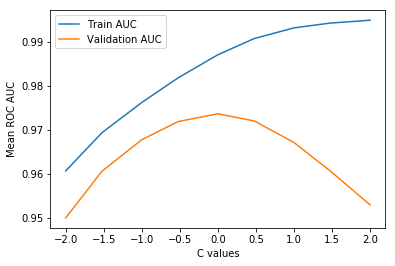

In [39]:
plot.plot(np.log10(alphas), train_roc_mean, label="Train AUC")
plot.plot(np.log10(alphas), val_roc_mean, label="Validation AUC")
plot.xlabel("C values")
plot.ylabel("Mean ROC AUC")
plot.legend()
plot.show()

In [40]:
alphas= [0.5, 1, 1.5, 2, 2.5, 3]
train_roc_mean=[]
val_roc_mean=[]
for alp in alphas:
    print("for C=", alp)
    train_rocs = []
    valid_rocs = []

    preds_train = np.zeros(y_train.shape)
    preds_valid = np.zeros(y_val.shape)
    for i, label_name in enumerate(labels):
        # fit
        model = LogisticRegression(C=alp)
        model.fit(X_train,y_train[label_name])

        # train
        preds_train[:,i] = model.predict_proba(X_train)[:,1]
        train_roc_class = roc_auc_score(y_train[label_name],preds_train[:,i])
        train_rocs.append(train_roc_class)

        # valid
        preds_valid[:,i] = model.predict_proba(X_val)[:,1]
        valid_roc_class = roc_auc_score(y_val[label_name],preds_valid[:,i])
        valid_rocs.append(valid_roc_class)

    print('\nmean column-wise ROC AUC on Train data: ', np.mean(train_rocs))
    train_roc_mean.append(np.mean(train_rocs))
    print('mean column-wise ROC AUC on Val data:', np.mean(valid_rocs))
    val_roc_mean.append(np.mean(valid_rocs))
    print('*'*50)

for C= 0.5

mean column-wise ROC AUC on Train data:  0.9841146113528881
mean column-wise ROC AUC on Val data: 0.9730250039538642
**************************************************
for C= 1

mean column-wise ROC AUC on Train data:  0.9869967581598035
mean column-wise ROC AUC on Val data: 0.9736092438933243
**************************************************
for C= 1.5

mean column-wise ROC AUC on Train data:  0.988499883342388
mean column-wise ROC AUC on Val data: 0.9733812943884753
**************************************************
for C= 2

mean column-wise ROC AUC on Train data:  0.9894664565906254
mean column-wise ROC AUC on Val data: 0.9729600074733468
**************************************************
for C= 2.5

mean column-wise ROC AUC on Train data:  0.9901516330301168
mean column-wise ROC AUC on Val data: 0.9724813103058153
**************************************************
for C= 3

mean column-wise ROC AUC on Train data:  0.9906705683605713
mean column-wise ROC AUC on Val dat

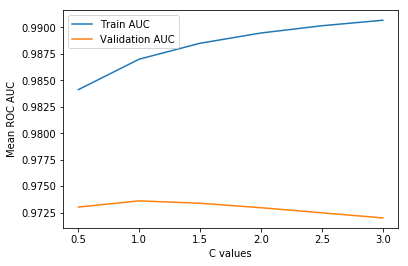

In [41]:
plot.plot(alphas, train_roc_mean, label="Train AUC")
plot.plot(alphas, val_roc_mean, label="Validation AUC")
plot.xlabel("C values")
plot.ylabel("Mean ROC AUC")
plot.legend()
plot.show()

#### 3.3.2 LR Model with tuned C

In [67]:
model = LogisticRegression(C=1)

train_rocs = []
valid_rocs = []

preds_train = np.zeros(y_train.shape)
preds_valid = np.zeros(y_val.shape)
preds_test = np.zeros((len(test_data), len(labels)))

for i, label_name in enumerate(labels):
    print('\nClass:= '+label_name)
    # fit
    model.fit(X_train,y_train[label_name])
    
    # train
    preds_train[:,i] = model.predict_proba(X_train)[:,1]
    train_roc_class = roc_auc_score(y_train[label_name],preds_train[:,i])
    print('Train ROC AUC:', train_roc_class)
    train_rocs.append(train_roc_class)

    # valid
    preds_valid[:,i] = model.predict_proba(X_val)[:,1]
    valid_roc_class = roc_auc_score(y_val[label_name],preds_valid[:,i])
    print('Valid ROC AUC:', valid_roc_class)
    valid_rocs.append(valid_roc_class)
    
    # test predictions
    preds_test[:,i] = model.predict_proba(X_test)[:,1]
    
print('\nmean column-wise ROC AUC on Train data: ', np.mean(train_rocs))
print('mean column-wise ROC AUC on Val data:', np.mean(valid_rocs))


Class:= toxic
Train ROC AUC: 0.9780188873089515
Valid ROC AUC: 0.9648575882452063

Class:= severe_toxic
Train ROC AUC: 0.9905106590102156
Valid ROC AUC: 0.9814785081804605

Class:= obscene
Train ROC AUC: 0.9901677297191414
Valid ROC AUC: 0.9794587933285638

Class:= threat
Train ROC AUC: 0.9938611663006507
Valid ROC AUC: 0.9805211072863553

Class:= insult
Train ROC AUC: 0.9830649218117186
Valid ROC AUC: 0.9730099791904906

Class:= identity_hate
Train ROC AUC: 0.9863571848081442
Valid ROC AUC: 0.9623294871288692

mean column-wise ROC AUC on Train data:  0.9869967581598035
mean column-wise ROC AUC on Val data: 0.9736092438933243


#### 3.3.3 Prediction on test data

In [68]:
submission = pd.DataFrame()
submission['id']= test_data.id

In [69]:
i=0
for lab in labels:
    submission[lab]= preds_test[:,i]
    i+=1
submission.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.999577,0.290275,0.998708,0.055111,0.977366,0.517051
1,0000247867823ef7,0.009613,0.003850,0.005704,0.001660,0.009079,0.003409
2,00013b17ad220c46,0.119847,0.007554,0.028889,0.002276,0.026148,0.008345
3,00017563c3f7919a,0.004832,0.002303,0.003598,0.001123,0.004191,0.000947
4,00017695ad8997eb,0.038326,0.001228,0.006754,0.000488,0.011149,0.000749


In [70]:
submission.to_csv("test_pred_LR1.csv", index=False)

### 3.4 SVM
#### 3.4.1 hyper parameter tuning

In [42]:
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
import warnings
warnings.filterwarnings("ignore")

alphas= [0.000001, 0.00001, 0.0001,0.001,0.01, 0.1,1, 10]
train_roc_mean=[]
val_roc_mean=[]
for alp in alphas:
    print("for alpha=", alp)
    train_rocs = []
    valid_rocs = []

    preds_train = np.zeros(y_train.shape)
    preds_valid = np.zeros(y_val.shape)
    for i, label_name in enumerate(labels):
        # fit
        modelsgd = SGDClassifier(alpha=alp)
        modelsgd.fit(X_train,y_train[label_name])
        model=CalibratedClassifierCV(modelsgd, cv='prefit', method= 'sigmoid')
        model.fit(X_train,y_train[label_name])

        # train
        preds_train[:,i] = model.predict_proba(X_train)[:,1]
        train_roc_class = roc_auc_score(y_train[label_name],preds_train[:,i])
        train_rocs.append(train_roc_class)

        # valid
        preds_valid[:,i] = model.predict_proba(X_val)[:,1]
        valid_roc_class = roc_auc_score(y_val[label_name],preds_valid[:,i])
        valid_rocs.append(valid_roc_class)

    print('\nmean column-wise ROC AUC on Train data: ', np.mean(train_rocs))
    train_roc_mean.append(np.mean(train_rocs))
    print('mean column-wise ROC AUC on Val data:', np.mean(valid_rocs))
    val_roc_mean.append(np.mean(valid_rocs))
    print('*'*50)

for alpha= 1e-06

mean column-wise ROC AUC on Train data:  0.9851218556403406
mean column-wise ROC AUC on Val data: 0.9473076888304311
**************************************************
for alpha= 1e-05

mean column-wise ROC AUC on Train data:  0.9859174036214874
mean column-wise ROC AUC on Val data: 0.9575892729460976
**************************************************
for alpha= 0.0001

mean column-wise ROC AUC on Train data:  0.9832336949426733
mean column-wise ROC AUC on Val data: 0.9618978674867517
**************************************************
for alpha= 0.001

mean column-wise ROC AUC on Train data:  0.9808165832286756
mean column-wise ROC AUC on Val data: 0.961385832607372
**************************************************
for alpha= 0.01

mean column-wise ROC AUC on Train data:  0.9806687375183228
mean column-wise ROC AUC on Val data: 0.9586291390180869
**************************************************
for alpha= 0.1

mean column-wise ROC AUC on Train data:  0.762048093220

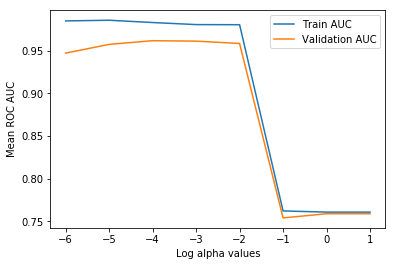

In [44]:
plot.plot(np.log10(alphas), train_roc_mean, label="Train AUC")
plot.plot(np.log10(alphas), val_roc_mean, label="Validation AUC")
plot.xlabel("Log alpha values")
plot.ylabel("Mean ROC AUC")
plot.legend()
plot.show()

#### 3.4.2 SVM Model with tuned alpha

In [83]:
modelsgd = SGDClassifier(alpha=0.001)

train_rocs = []
valid_rocs = []

preds_train = np.zeros(y_train.shape)
preds_valid = np.zeros(y_val.shape)
preds_test = np.zeros((len(test_data), len(labels)))

for i, label_name in enumerate(labels):
    print('\nClass:= '+label_name)
    # fit
    modelsgd.fit(X_train,y_train[label_name])
    model=CalibratedClassifierCV(modelsgd, cv='prefit', method= 'sigmoid')
    model.fit(X_train,y_train[label_name])
    
    # train
    preds_train[:,i] = model.predict_proba(X_train)[:,1]
    train_roc_class = roc_auc_score(y_train[label_name],preds_train[:,i])
    print('Train ROC AUC:', train_roc_class)
    train_rocs.append(train_roc_class)

    # valid
    preds_valid[:,i] = model.predict_proba(X_val)[:,1]
    valid_roc_class = roc_auc_score(y_val[label_name],preds_valid[:,i])
    print('Valid ROC AUC:', valid_roc_class)
    valid_rocs.append(valid_roc_class)
    
    # test predictions
    preds_test[:,i] = model.predict_proba(X_test)[:,1]
    
print('\nmean column-wise ROC AUC on Train data: ', np.mean(train_rocs))
print('mean column-wise ROC AUC on Val data:', np.mean(valid_rocs))


Class:= toxic
Train ROC AUC: 0.964212852756118
Valid ROC AUC: 0.9593357901042857

Class:= severe_toxic
Train ROC AUC: 0.9886401388353874
Valid ROC AUC: 0.9639282022490694

Class:= obscene
Train ROC AUC: 0.9839463445475733
Valid ROC AUC: 0.9744046772538126

Class:= threat
Train ROC AUC: 0.997208778597442
Valid ROC AUC: 0.9669374792786244

Class:= insult
Train ROC AUC: 0.9673047244432166
Valid ROC AUC: 0.9617462981927624

Class:= identity_hate
Train ROC AUC: 0.9874475795611554
Valid ROC AUC: 0.9447501283164876

mean column-wise ROC AUC on Train data:  0.9814600697901489
mean column-wise ROC AUC on Val data: 0.9618504292325071


#### 3.4.3 Prediction on test data

In [84]:
submission = pd.DataFrame()
submission['id']= test_data.id

In [85]:
i=0
for lab in labels:
    submission[lab]= preds_test[:,i]
    i+=1
submission.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,1.000000,0.346314,0.998408,0.026987,0.768006,0.074627
1,0000247867823ef7,0.031744,0.000923,0.017322,0.000014,0.028347,0.004650
2,00013b17ad220c46,0.077417,0.002253,0.023325,0.000027,0.032195,0.012066
3,00017563c3f7919a,0.022035,0.004957,0.015411,0.000081,0.023885,0.002916
4,00017695ad8997eb,0.046499,0.001832,0.017734,0.000030,0.022184,0.004450


In [86]:
submission.to_csv("test_pred_SVM.csv", index=False)

### 3.5 Logistic Regression2
#### 3.5.1 hyper parameter tuning

In [45]:
X_train, X_val, y_train, y_val = train_test_split(data['cleared_text1'], 
                                                  data[labels], test_size=0.1, random_state=1919)
X_test=test_data['cleared_text1']

vec = TfidfVectorizer(ngram_range=(1,3),
               min_df=10, max_df=0.9, strip_accents='unicode', use_idf=1,
               smooth_idf=1, sublinear_tf=1 )
X_train = vec.fit_transform(X_train)
X_val = vec.transform(X_val)
X_test = vec.transform(X_test)

In [46]:
alphas= [0.1,0.5, 1,2,3,4]
train_roc_mean=[]
val_roc_mean=[]
for alp in alphas:
    print("for C=", alp)
    train_rocs = []
    valid_rocs = []

    preds_train = np.zeros(y_train.shape)
    preds_valid = np.zeros(y_val.shape)
    for i, label_name in enumerate(labels):
        # fit
        model = LogisticRegression(C=alp)
        model.fit(X_train,y_train[label_name])

        # train
        preds_train[:,i] = model.predict_proba(X_train)[:,1]
        train_roc_class = roc_auc_score(y_train[label_name],preds_train[:,i])
        train_rocs.append(train_roc_class)

        # valid
        preds_valid[:,i] = model.predict_proba(X_val)[:,1]
        valid_roc_class = roc_auc_score(y_val[label_name],preds_valid[:,i])
        valid_rocs.append(valid_roc_class)

    print('\nmean column-wise ROC AUC on Train data: ', np.mean(train_rocs))
    train_roc_mean.append(np.mean(train_rocs))
    print('mean column-wise ROC AUC on Val data:', np.mean(valid_rocs))
    val_roc_mean.append(np.mean(valid_rocs))
    print('*'*50)

for C= 0.1

mean column-wise ROC AUC on Train data:  0.979391409671884
mean column-wise ROC AUC on Val data: 0.9708983570784514
**************************************************
for C= 0.5

mean column-wise ROC AUC on Train data:  0.9876736643175636
mean column-wise ROC AUC on Val data: 0.976517399661868
**************************************************
for C= 1

mean column-wise ROC AUC on Train data:  0.9912894855622932
mean column-wise ROC AUC on Val data: 0.9779113180471359
**************************************************
for C= 2

mean column-wise ROC AUC on Train data:  0.9944158298533184
mean column-wise ROC AUC on Val data: 0.9781858189624962
**************************************************
for C= 3

mean column-wise ROC AUC on Train data:  0.995873858798145
mean column-wise ROC AUC on Val data: 0.9778106754208529
**************************************************
for C= 4

mean column-wise ROC AUC on Train data:  0.9967144796589809
mean column-wise ROC AUC on Val data: 0

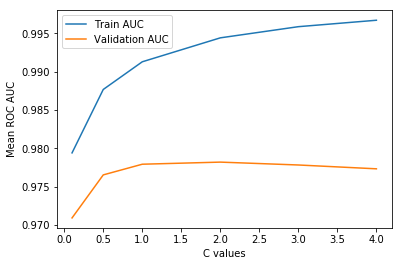

In [47]:
plot.plot(alphas, train_roc_mean, label="Train AUC")
plot.plot(alphas, val_roc_mean, label="Validation AUC")
plot.xlabel("C values")
plot.ylabel("Mean ROC AUC")
plot.legend()
plot.show()

#### 3.5.2 LR2 Model with tuned C

In [89]:
model = LogisticRegression(C=2)

train_rocs = []
valid_rocs = []

preds_train = np.zeros(y_train.shape)
preds_valid = np.zeros(y_val.shape)
preds_test = np.zeros((len(test_data), len(labels)))

for i, label_name in enumerate(labels):
    print('\nClass:= '+label_name)
    # fit
    model.fit(X_train,y_train[label_name])
    
    # train
    preds_train[:,i] = model.predict_proba(X_train)[:,1]
    train_roc_class = roc_auc_score(y_train[label_name],preds_train[:,i])
    print('Train ROC AUC:', train_roc_class)
    train_rocs.append(train_roc_class)

    # valid
    preds_valid[:,i] = model.predict_proba(X_val)[:,1]
    valid_roc_class = roc_auc_score(y_val[label_name],preds_valid[:,i])
    print('Valid ROC AUC:', valid_roc_class)
    valid_rocs.append(valid_roc_class)
    
    # test predictions
    preds_test[:,i] = model.predict_proba(X_test)[:,1]
    
print('\nmean column-wise ROC AUC on Train data: ', np.mean(train_rocs))
print('mean column-wise ROC AUC on Val data:', np.mean(valid_rocs))


Class:= toxic
Train ROC AUC: 0.9914819516826907
Valid ROC AUC: 0.9693451357265814

Class:= severe_toxic
Train ROC AUC: 0.9944824878091023
Valid ROC AUC: 0.9872948267503289

Class:= obscene
Train ROC AUC: 0.9961164151823908
Valid ROC AUC: 0.9831184030941582

Class:= threat
Train ROC AUC: 0.9979666252465946
Valid ROC AUC: 0.9868769062333096

Class:= insult
Train ROC AUC: 0.9922503968306162
Valid ROC AUC: 0.9743687567842443

Class:= identity_hate
Train ROC AUC: 0.9941971023685163
Valid ROC AUC: 0.968110885186355

mean column-wise ROC AUC on Train data:  0.9944158298533184
mean column-wise ROC AUC on Val data: 0.9781858189624962


#### 3.5.3 Prediction on test data

In [90]:
submission = pd.DataFrame()
submission['id']= test_data.id

In [91]:
i=0
for lab in labels:
    submission[lab]= preds_test[:,i]
    i+=1
submission.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.999300,0.210607,0.997974,0.038784,0.949908,0.364595
1,0000247867823ef7,0.003894,0.002484,0.003067,0.001094,0.006326,0.002330
2,00013b17ad220c46,0.119422,0.005506,0.022499,0.001670,0.019493,0.007020
3,00017563c3f7919a,0.005042,0.001977,0.002873,0.001180,0.003152,0.000870
4,00017695ad8997eb,0.017262,0.001570,0.005401,0.000616,0.010236,0.001010


In [92]:
submission.to_csv("test_pred_LR2.csv", index=False)

### 3.6 NB-SVM
#### 3.6.1 NB-SVM modeling

In [133]:
# ref: https://www.kaggle.com/jhoward/nb-svm-strong-linear-baseline
# NB-SVM
def pr(y_i, y):
    p = x[y==y_i].sum(0)
    return (p+1) / ((y==y_i).sum()+1)

In [134]:
x = X_train
test_x = X_val

In [135]:
def get_mdl(y):
    y = y.values
    r = np.log(pr(1,y) / pr(0,y))
    m = LogisticRegression(C=4, dual=True)
    x_nb = x.multiply(r)
    return m.fit(x_nb, y), r

In [136]:
train_rocs = []
valid_rocs = []

preds_train = np.zeros(y_train.shape)
preds_valid = np.zeros(y_val.shape)
preds_test = np.zeros((len(test_data), len(labels)))

for i, label_name in enumerate(labels):
    print('\nClass:= '+label_name)
    # fit
    model,r = get_mdl(y_train[label_name])
    #model.fit(X_train,)
    
    # train
    preds_train[:,i] = model.predict_proba(X_train.multiply(r))[:,1]
    train_roc_class = roc_auc_score(y_train[label_name],preds_train[:,i])
    print('Train ROC AUC:', train_roc_class)
    train_rocs.append(train_roc_class)

    # valid
    preds_valid[:,i] = model.predict_proba(X_val.multiply(r))[:,1]
    valid_roc_class = roc_auc_score(y_val[label_name],preds_valid[:,i])
    print('Valid ROC AUC:', valid_roc_class)
    valid_rocs.append(valid_roc_class)
    
    # test predictions
    preds_test[:,i] = model.predict_proba(X_test.multiply(r))[:,1]
    
print('\nmean column-wise ROC AUC on Train data: ', np.mean(train_rocs))
print('mean column-wise ROC AUC on Val data:', np.mean(valid_rocs))


Class:= toxic
Train ROC AUC: 0.9793015297520724
Valid ROC AUC: 0.9662317652500112

Class:= severe_toxic
Train ROC AUC: 0.9940141622446979
Valid ROC AUC: 0.9804576920290662

Class:= obscene
Train ROC AUC: 0.990485960236388
Valid ROC AUC: 0.9804965234460078

Class:= threat
Train ROC AUC: 0.9993968744373798
Valid ROC AUC: 0.9705897716624327

Class:= insult
Train ROC AUC: 0.9835116969658667
Valid ROC AUC: 0.9720578933244072

Class:= identity_hate
Train ROC AUC: 0.991683789323279
Valid ROC AUC: 0.9555440125552748

mean column-wise ROC AUC on Train data:  0.9897323354932807
mean column-wise ROC AUC on Val data: 0.9708962763778666


#### 3.6.2 Prediction on test data

In [137]:
submission = pd.DataFrame()
submission['id']= test_data.id

In [138]:
i=0
for lab in labels:
    submission[lab]= preds_test[:,i]
    i+=1
submission.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.999996,0.435986,0.999976,0.056048,0.992826,0.783812
1,0000247867823ef7,0.002547,0.001184,0.001263,0.000135,0.004204,0.000691
2,00013b17ad220c46,0.047265,0.001802,0.010657,0.000122,0.013883,0.006360
3,00017563c3f7919a,0.001564,0.000909,0.001230,0.000177,0.002566,0.000092
4,00017695ad8997eb,0.038281,0.000446,0.004149,0.000029,0.011418,0.000120


In [139]:
submission.to_csv("test_pred_NB-SVM.csv", index=False)

### 3.7 Random Forest
#### 3.7.1 Random Forest Modeling


In [105]:
X_train, X_val, y_train, y_val = train_test_split(data['cleared_text1'], 
                                                  data[labels], test_size=0.1, random_state=1919)
X_test=test_data['cleared_text1']
tfidf = TfidfVectorizer(ngram_range = (1,3), min_df = 150)
X_train = tfidf.fit_transform(X_train)
X_val = tfidf.transform(X_val)
X_test = tfidf.transform(X_test)

print('Final Data dimensions after transformations:', X_train.shape, y_train.shape, X_val.shape, y_val.shape)

Final Data dimensions after transformations: (143613, 5075) (143613, 6) (15958, 5075) (15958, 6)


In [106]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

In [107]:

model=RandomForestClassifier(n_estimators=150,max_depth=60,max_features='auto')

train_rocs = []
valid_rocs = []

preds_train = np.zeros(y_train.shape)
preds_valid = np.zeros(y_val.shape)
preds_test = np.zeros((len(test_data), len(labels)))

for i, label_name in enumerate(labels):
    print('\nClass:= '+label_name)
    # fit
    model.fit(X_train,y_train[label_name])
    
    # train
    preds_train[:,i] = model.predict_proba(X_train)[:,1]
    train_roc_class = roc_auc_score(y_train[label_name],preds_train[:,i])
    print('Train ROC AUC:', train_roc_class)
    train_rocs.append(train_roc_class)

    # valid
    preds_valid[:,i] = model.predict_proba(X_val)[:,1]
    valid_roc_class = roc_auc_score(y_val[label_name],preds_valid[:,i])
    print('Valid ROC AUC:', valid_roc_class)
    valid_rocs.append(valid_roc_class)
    
    # test predictions
    preds_test[:,i] = model.predict_proba(X_test)[:,1]
    
print('\nmean column-wise ROC AUC on Train data: ', np.mean(train_rocs))
print('mean column-wise ROC AUC on Val data:', np.mean(valid_rocs))


Class:= toxic
Train ROC AUC: 0.9922514391113061
Valid ROC AUC: 0.9443152751214732

Class:= severe_toxic
Train ROC AUC: 0.9973162854864863
Valid ROC AUC: 0.9773060832423155

Class:= obscene
Train ROC AUC: 0.9971215749522314
Valid ROC AUC: 0.9712960792939039

Class:= threat
Train ROC AUC: 0.9993902075802632
Valid ROC AUC: 0.9324656384955455

Class:= insult
Train ROC AUC: 0.994888394983711
Valid ROC AUC: 0.9598697093263683

Class:= identity_hate
Train ROC AUC: 0.9975863111512552
Valid ROC AUC: 0.9343986891977258

mean column-wise ROC AUC on Train data:  0.9964257022108756
mean column-wise ROC AUC on Val data: 0.9532752457795555


#### 3.7.2 Prediction on test data

In [108]:
submission = pd.DataFrame()
submission['id']= test_data.id

In [109]:
i=0
for lab in labels:
    submission[lab]= preds_test[:,i]
    i+=1
submission.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.877610,0.172997,0.809736,0.074539,0.697454,0.108143
1,0000247867823ef7,0.072948,0.003768,0.031091,0.000652,0.030761,0.003552
2,00013b17ad220c46,0.078572,0.003775,0.032298,0.000652,0.031526,0.003552
3,00017563c3f7919a,0.031431,0.002003,0.023172,0.000631,0.012816,0.002525
4,00017695ad8997eb,0.040931,0.008226,0.012516,0.000460,0.014427,0.001736


In [110]:
submission.to_csv("test_pred_NB-SVM.csv", index=False)

### 3.8 LR WordGrams and CharacterGrams
#### 3.8.1 featurization


In [30]:
X_train, X_val, y_train, y_val = train_test_split(data['cleared_text1'], 
                                                  data[labels], test_size=0.1, random_state=1919)
X_test=test_data['cleared_text1']

word_vec = TfidfVectorizer(ngram_range=(1,2), analyzer='word',max_features=12000,
               strip_accents='unicode', use_idf=1,
               smooth_idf=1, sublinear_tf=1 )
X_trainw = word_vec.fit_transform(X_train)
X_valw = word_vec.transform(X_val)
X_testw = word_vec.transform(X_test)

In [31]:
char_vec = TfidfVectorizer(ngram_range=(2,6), analyzer='char',max_features=50000,
               strip_accents='unicode', use_idf=1,
               smooth_idf=1, sublinear_tf=1 )
X_trainc = char_vec.fit_transform(X_train)
X_valc = char_vec.transform(X_val)
X_testc = char_vec.transform(X_test)

In [32]:
from scipy.sparse import hstack

X_train=hstack([X_trainw, X_trainc])
X_val=hstack([X_valw, X_valc])
X_test= hstack([X_testw, X_testc]) 

print(X_train.shape)

(143613, 62000)


#### 3.8.2 LR Model

In [35]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
alphas= [1,2,3]
train_roc_mean=[]
val_roc_mean=[]
for alp in alphas:
    print("for C=", alp)
    train_rocs = []
    valid_rocs = []

    preds_train = np.zeros(y_train.shape)
    preds_valid = np.zeros(y_val.shape)
    for i, label_name in enumerate(labels):
        # fit
        model = LogisticRegression(C=alp)
        model.fit(X_train,y_train[label_name])

        # train
        preds_train[:,i] = model.predict_proba(X_train)[:,1]
        train_roc_class = roc_auc_score(y_train[label_name],preds_train[:,i])
        train_rocs.append(train_roc_class)

        # valid
        preds_valid[:,i] = model.predict_proba(X_val)[:,1]
        valid_roc_class = roc_auc_score(y_val[label_name],preds_valid[:,i])
        valid_rocs.append(valid_roc_class)

    print('\nmean column-wise ROC AUC on Train data: ', np.mean(train_rocs))
    train_roc_mean.append(np.mean(train_rocs))
    print('mean column-wise ROC AUC on Val data:', np.mean(valid_rocs))
    val_roc_mean.append(np.mean(valid_rocs))
    print('*'*50)

for C= 1

mean column-wise ROC AUC on Train data:  0.9940603352616578
mean column-wise ROC AUC on Val data: 0.9816312508927254
**************************************************
for C= 2

mean column-wise ROC AUC on Train data:  0.9962599440866207
mean column-wise ROC AUC on Val data: 0.9812192767142355
**************************************************
for C= 3

mean column-wise ROC AUC on Train data:  0.9972877396027896
mean column-wise ROC AUC on Val data: 0.9805176126183208
**************************************************


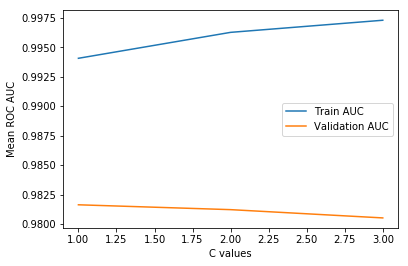

In [36]:
plot.plot(alphas, train_roc_mean, label="Train AUC")
plot.plot(alphas, val_roc_mean, label="Validation AUC")
plot.xlabel("C values")
plot.ylabel("Mean ROC AUC")
plot.legend()
plot.show()

In [124]:
model = LogisticRegression(C=1)

train_rocs = []
valid_rocs = []

preds_train = np.zeros(y_train.shape)
preds_valid = np.zeros(y_val.shape)
preds_test = np.zeros((len(test_data), len(labels)))

for i, label_name in enumerate(labels):
    print('\nClass:= '+label_name)
    # fit
    model.fit(X_train,y_train[label_name])
    
    # train
    preds_train[:,i] = model.predict_proba(X_train)[:,1]
    train_roc_class = roc_auc_score(y_train[label_name],preds_train[:,i])
    print('Train ROC AUC:', train_roc_class)
    train_rocs.append(train_roc_class)

    # valid
    preds_valid[:,i] = model.predict_proba(X_val)[:,1]
    valid_roc_class = roc_auc_score(y_val[label_name],preds_valid[:,i])
    print('Valid ROC AUC:', valid_roc_class)
    valid_rocs.append(valid_roc_class)
    
    # test predictions
    preds_test[:,i] = model.predict_proba(X_test)[:,1]
    
print('\nmean column-wise ROC AUC on Train data: ', np.mean(train_rocs))
print('mean column-wise ROC AUC on Val data:', np.mean(valid_rocs))


Class:= toxic
Train ROC AUC: 0.989207086204653
Valid ROC AUC: 0.9724931171299626

Class:= severe_toxic
Train ROC AUC: 0.9947881038338992
Valid ROC AUC: 0.9876049723602969

Class:= obscene
Train ROC AUC: 0.9964868315941662
Valid ROC AUC: 0.9893221606197531

Class:= threat
Train ROC AUC: 0.997415809511625
Valid ROC AUC: 0.9836563647004768

Class:= insult
Train ROC AUC: 0.9912788410184878
Valid ROC AUC: 0.9810145268377137

Class:= identity_hate
Train ROC AUC: 0.9951853394071156
Valid ROC AUC: 0.9756963637081492

mean column-wise ROC AUC on Train data:  0.9940603352616578
mean column-wise ROC AUC on Val data: 0.9816312508927254


#### 3.8.3 Prediction on test data

In [125]:
submission = pd.DataFrame()
submission['id']= test_data.id

In [126]:
i=0
for lab in labels:
    submission[lab]= preds_test[:,i]
    i+=1
submission.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.999955,0.279281,0.999892,0.064325,0.991839,0.439833
1,0000247867823ef7,0.008825,0.003128,0.003799,0.001344,0.007943,0.002206
2,00013b17ad220c46,0.051237,0.003590,0.011305,0.001422,0.007983,0.003532
3,00017563c3f7919a,0.003036,0.001953,0.002554,0.000785,0.002516,0.000345
4,00017695ad8997eb,0.015663,0.001920,0.004481,0.000605,0.006929,0.001557


In [127]:
submission.to_csv("test_pred_LR_W&C-Grams.csv", index=False)

## 4. Comparing Model Result

In [40]:
from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["Model Description/(Score- Mean ROC AUC)", "Kaggle Private Score", 
                 "Kaggle Public Score", "Local Val Score"]

x.add_row(["Naive Bayes", 0.95570, 0.95347, 0.9565])
x.add_row(["SVM", 0.95643, 0.96053, 0.9619])
x.add_row(["Naive Bayes - SVM", 0.96727, 0.96630, 0.9709])
x.add_row(["Logistic Regression Limited features (10K)", 0.97121, 0.97055, 0.9736])
x.add_row(["Logistic Regression v2", 0.97489, 0.97396, 0.9782])
x.add_row(["Logistic Regression Word and Character Grams", 0.97855, 0.97706, 0.9816])
x.add_row(["Random Forest", 0.95350, 0.95273, 0.9533])

print(x)

+----------------------------------------------+----------------------+---------------------+-----------------+
|   Model Description/(Score- Mean ROC AUC)    | Kaggle Private Score | Kaggle Public Score | Local Val Score |
+----------------------------------------------+----------------------+---------------------+-----------------+
|                 Naive Bayes                  |        0.9557        |       0.95347       |      0.9565     |
|                     SVM                      |       0.95643        |       0.96053       |      0.9619     |
|              Naive Bayes - SVM               |       0.96727        |        0.9663       |      0.9709     |
|  Logistic Regression Limited features (10K)  |       0.97121        |       0.97055       |      0.9736     |
|            Logistic Regression v2            |       0.97489        |       0.97396       |      0.9782     |
| Logistic Regression Word and Character Grams |       0.97855        |       0.97706       |      0.981

## References
 - https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/
 - https://medium.com/@datamonsters/text-preprocessing-in-python-steps-tools-and-examples-bf025f872908
 - https://www.kaggle.com/asrsaiteja/toxic-comments-featureeng-eda-with-nb-baseline
 - https://sijunhe.github.io/blog/2018/04/03/nb-svm/
 - https://www.kaggle.com/jhoward/nb-svm-strong-linear-baseline